In [2]:

from IPython.display import HTML
from base64 import b64encode
import imgaug.augmenters as iaa
import math

import numpy as np
import cv2
import os
from keras.models import load_model
from collections import deque
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib
matplotlib.use("Agg")
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2
from keras import regularizers
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import seaborn as sns
from sklearn import metrics




# All the necessary packages have been imported.

In [7]:
PROJECT_DIR = '../input/real-life-violence-situations-dataset'

In [8]:
!dir {PROJECT_DIR}

Invalid switch - "input".


In [9]:
from IPython.display import HTML
from base64 import b64encode

def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

#  Function to play the video for violence detection.

In [11]:
play('./input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_192.mp4')

In [6]:
IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    
    
    rate = math.floor(vidcap.get(3))
    count = 0
    
    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()
        
        if success:
            # skipping frames to avoid duplications 
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))
                
                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)
                
                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)
                
            count += 1
        else:
            break
    
    vidcap.release()
    
    return ImageFrames

# Function to split the video into frames to analyse.

In [7]:
%%time
from tqdm import tqdm

VideoDataDir = PROJECT_DIR + '/Real Life Violence Dataset'
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')), 
              len(os.listdir(VideoDataDir + '/NonViolence'))))

X_original = []
y_original = []

print('Choosing 200 videos out of 1000 for each, cuz of memory issue')
CLASSES = ["NonViolence", "Violence"]


for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:200])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

we have 
1000 Violence videos 
1000 NonViolence videos
Choosing 200 videos out of 1000 for each, cuz of memory issue


100%|██████████| 200/200 [01:30<00:00,  2.20it/s]

CPU times: user 3min 25s, sys: 10.8 s, total: 3min 35s
Wall time: 2min 14s


# Creating Violence and Non Violence Dataset and using 200 images due to RAM constraints.

In [8]:
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

7804

In [9]:
stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

# Reshaping the image and using Stratified Shuffle Split.

In [10]:
epochs = 150


kernel_regularizer = regularizers.l2(0.001)


def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = ResNet50V2(weights = "imagenet", pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    headModel = baseModel.output   
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model


model = load_layers()

model.summary()

2022-11-08 07:49:09.942969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 07:49:09.944068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 07:49:10.340291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 07:49:10.341310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 07:49:10.342233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

94683136/94668760 [==============================] - 1s 0us/step
Compiling model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
__________

# Training the model for 150 epochs using ResNet50V2 and using imagenet weights.

In [11]:


patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 20



rampup_epochs = 30
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.99)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

# Stopping early if the accuracy is >= 99%.

In [12]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)



lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')


log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]



2022-11-08 07:49:18.864252: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-11-08 07:49:18.864291: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-11-08 07:49:18.868225: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2022-11-08 07:49:19.358050: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-11-08 07:49:19.358246: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


# Callback function to save weights if the loss is reduced.

In [13]:
print('Training head...')
batch_size = 50
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for ResNet50V2')
model.load_weights(checkpoint_filepath)

Training head...


2022-11-08 07:49:20.099416: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1073872896 exceeds 10% of free system memory.
2022-11-08 07:49:21.451344: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1073872896 exceeds 10% of free system memory.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-11-08 07:49:22.474342: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-11-08 07:49:27.771546: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/110 [..............................] - ETA: 31:05 - loss: 1.1558 - accuracy: 0.4600

2022-11-08 07:49:39.844075: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-11-08 07:49:39.844238: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/110 [..............................] - ETA: 1:50 - loss: 0.9938 - accuracy: 0.4900 

2022-11-08 07:49:40.709745: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-08 07:49:40.710464: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-11-08 07:49:40.870896: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 362 callback api events and 359 activity events. 
2022-11-08 07:49:40.890225: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


  4/110 [>.............................] - ETA: 50s - loss: 0.9807 - accuracy: 0.5100 

2022-11-08 07:49:40.930338: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/20221108-074918/train/plugins/profile/2022_11_08_07_49_40

2022-11-08 07:49:40.939764: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/fit/20221108-074918/train/plugins/profile/2022_11_08_07_49_40/49bd4ba135ca.trace.json.gz
2022-11-08 07:49:40.997065: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/20221108-074918/train/plugins/profile/2022_11_08_07_49_40

2022-11-08 07:49:41.005480: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/fit/20221108-074918/train/plugins/profile/2022_11_08_07_49_40/49bd4ba135ca.memory_profile.json.gz
2022-11-08 07:49:41.006744: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/fit/20221108-074918/train/plugins/profile/2022_11_08_07_49_40
D

110/110 [==============================] - 29s 112ms/step - loss: 0.9336 - accuracy: 0.5357 - val_loss: 0.8941 - val_accuracy: 0.5401

Epoch 00001: val_loss improved from inf to 0.89412, saving model to ModelWeights.h5


2022-11-08 07:49:54.184360: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 566231040 exceeds 10% of free system memory.
2022-11-08 07:49:55.097011: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 566231040 exceeds 10% of free system memory.
2022-11-08 07:49:55.725614: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 566231040 exceeds 10% of free system memory.


Epoch 2/150
110/110 [==============================] - 8s 73ms/step - loss: 0.8538 - accuracy: 0.5496 - val_loss: 0.8400 - val_accuracy: 0.5401

Epoch 00002: val_loss improved from 0.89412 to 0.83999, saving model to ModelWeights.h5
Epoch 3/150
110/110 [==============================] - 8s 73ms/step - loss: 0.8044 - accuracy: 0.5688 - val_loss: 0.7995 - val_accuracy: 0.5585

Epoch 00003: val_loss improved from 0.83999 to 0.79946, saving model to ModelWeights.h5
Epoch 4/150
110/110 [==============================] - 8s 73ms/step - loss: 0.7643 - accuracy: 0.5914 - val_loss: 0.7623 - val_accuracy: 0.5798

Epoch 00004: val_loss improved from 0.79946 to 0.76229, saving model to ModelWeights.h5
Epoch 5/150
110/110 [==============================] - 8s 71ms/step - loss: 0.7266 - accuracy: 0.6086 - val_loss: 0.7255 - val_accuracy: 0.5952

Epoch 00005: val_loss improved from 0.76229 to 0.72545, saving model to ModelWeights.h5
Epoch 6/150
110/110 [==============================] - 8s 71ms/step 

# Training the model.

In [14]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)

------------------------------------------------------------------------------------------
Best Epochs:  137
Accuracy on train: 0.9196265339851379 	Loss on train: 0.21429312229156494
Accuracy on test: 0.8988044261932373 	Loss on test: 0.25044387578964233


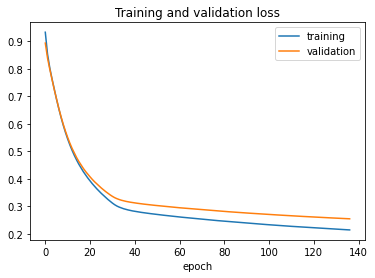

<Figure size 432x288 with 0 Axes>

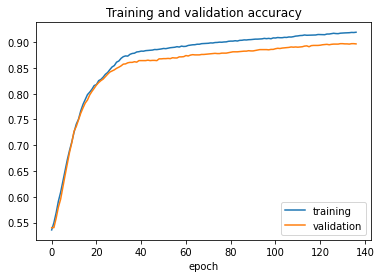

------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [15]:
model_summary(model, history)


# Training and validation accuracy is increasing while the loss is decreasing.

In [16]:
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.6

Evaluating network...


# Only choosing those images where the prediction accuracy is more than 60% sure whether the images are violence or non violence. 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

> Correct Predictions: 2103
> Wrong Predictions: 239


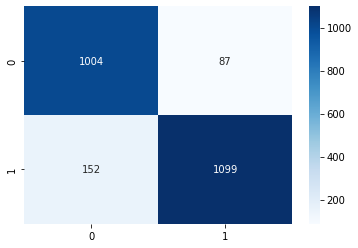

              precision    recall  f1-score   support

 NonViolence       0.87      0.92      0.89      1091
    Violence       0.93      0.88      0.90      1251

    accuracy                           0.90      2342
   macro avg       0.90      0.90      0.90      2342
weighted avg       0.90      0.90      0.90      2342



In [17]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds, 
                           target_names=["NonViolence", "Violence"]))

# Confusion matrix to show the accuracy.

In [18]:
args_model = "model.h5"
model.save(args_model)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [38]:
import numpy as np
import argparse
import pickle
import cv2
import os
import time
from keras.models import load_model
from collections import deque
import matplotlib.pyplot as plt
# %matplotlib inline

In [47]:


def print_results(video, limit=None):
        fig=plt.figure(figsize=(16, 30))
        if not os.path.exists('output'):
            os.mkdir('output')

        print("Loading model ...")
        model = load_model('./results/model.h5')
        Q = deque(maxlen=128)

        vs = cv2.VideoCapture(video)
        writer = None
        (W, H) = (None, None)
        count = 0     
        while True:
                (grabbed, frame) = vs.read()
                ID = vs.get(1)
                if not grabbed:
                    break
                try:
                    if (ID % 7 == 0):
                        count = count + 1
                        n_frames = len(frame)
                        
                        if W is None or H is None:
                            (H, W) = frame.shape[:2]

                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        output = cv2.resize(frame, (512, 360)).copy()
                        frame = cv2.resize(frame, (128, 128)).astype("float16")
                        IMG_SIZE = 128
                        frame = frame.reshape(IMG_SIZE, IMG_SIZE, 3) / 255
                        preds = model.predict(np.expand_dims(frame, axis=0))[0]
                        Q.append(preds)

                        results = np.array(Q).mean(axis=0)
                        i = (preds > 0.6)[0] #np.argmax(results)

                        label = i

                        text = "Violence: {}".format(label)
                        #print('prediction:', text)
                        file = open("output.txt",'w')
                        file.write(text)
                        file.close()

                        color = (0, 255, 0)

                        if label:
                            color = (255, 0, 0) 
                        else:
                            color = (0, 255, 0)

                        cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
                                1, color, 3)


                        # saving mp4 with labels but cv2.imshow is not working with this notebook
                        if writer is None:
                                fourcc = cv2.VideoWriter_fourcc(*"MJPG")
                                writer = cv2.VideoWriter("output.mp4", fourcc, 60,
                                        (W, H), True)

                        writer.write(output)
                        #cv2.imshow("Output", output)

                        fig.add_subplot(8, 3, count)
                        plt.imshow(output)

                    if limit and count > limit:
                        break

                except:
                    break 
        
        plt.show()
        print("Cleaning up...")
        if writer is not None:
            writer.release()
        vs.release()

In [40]:
Violence=r"./input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_192.mp4" 
play(Violence)

# The model is able to classify the frames with 90% accuracy.

Loading model ...
1/1 [==============================] - 0s 63ms/step


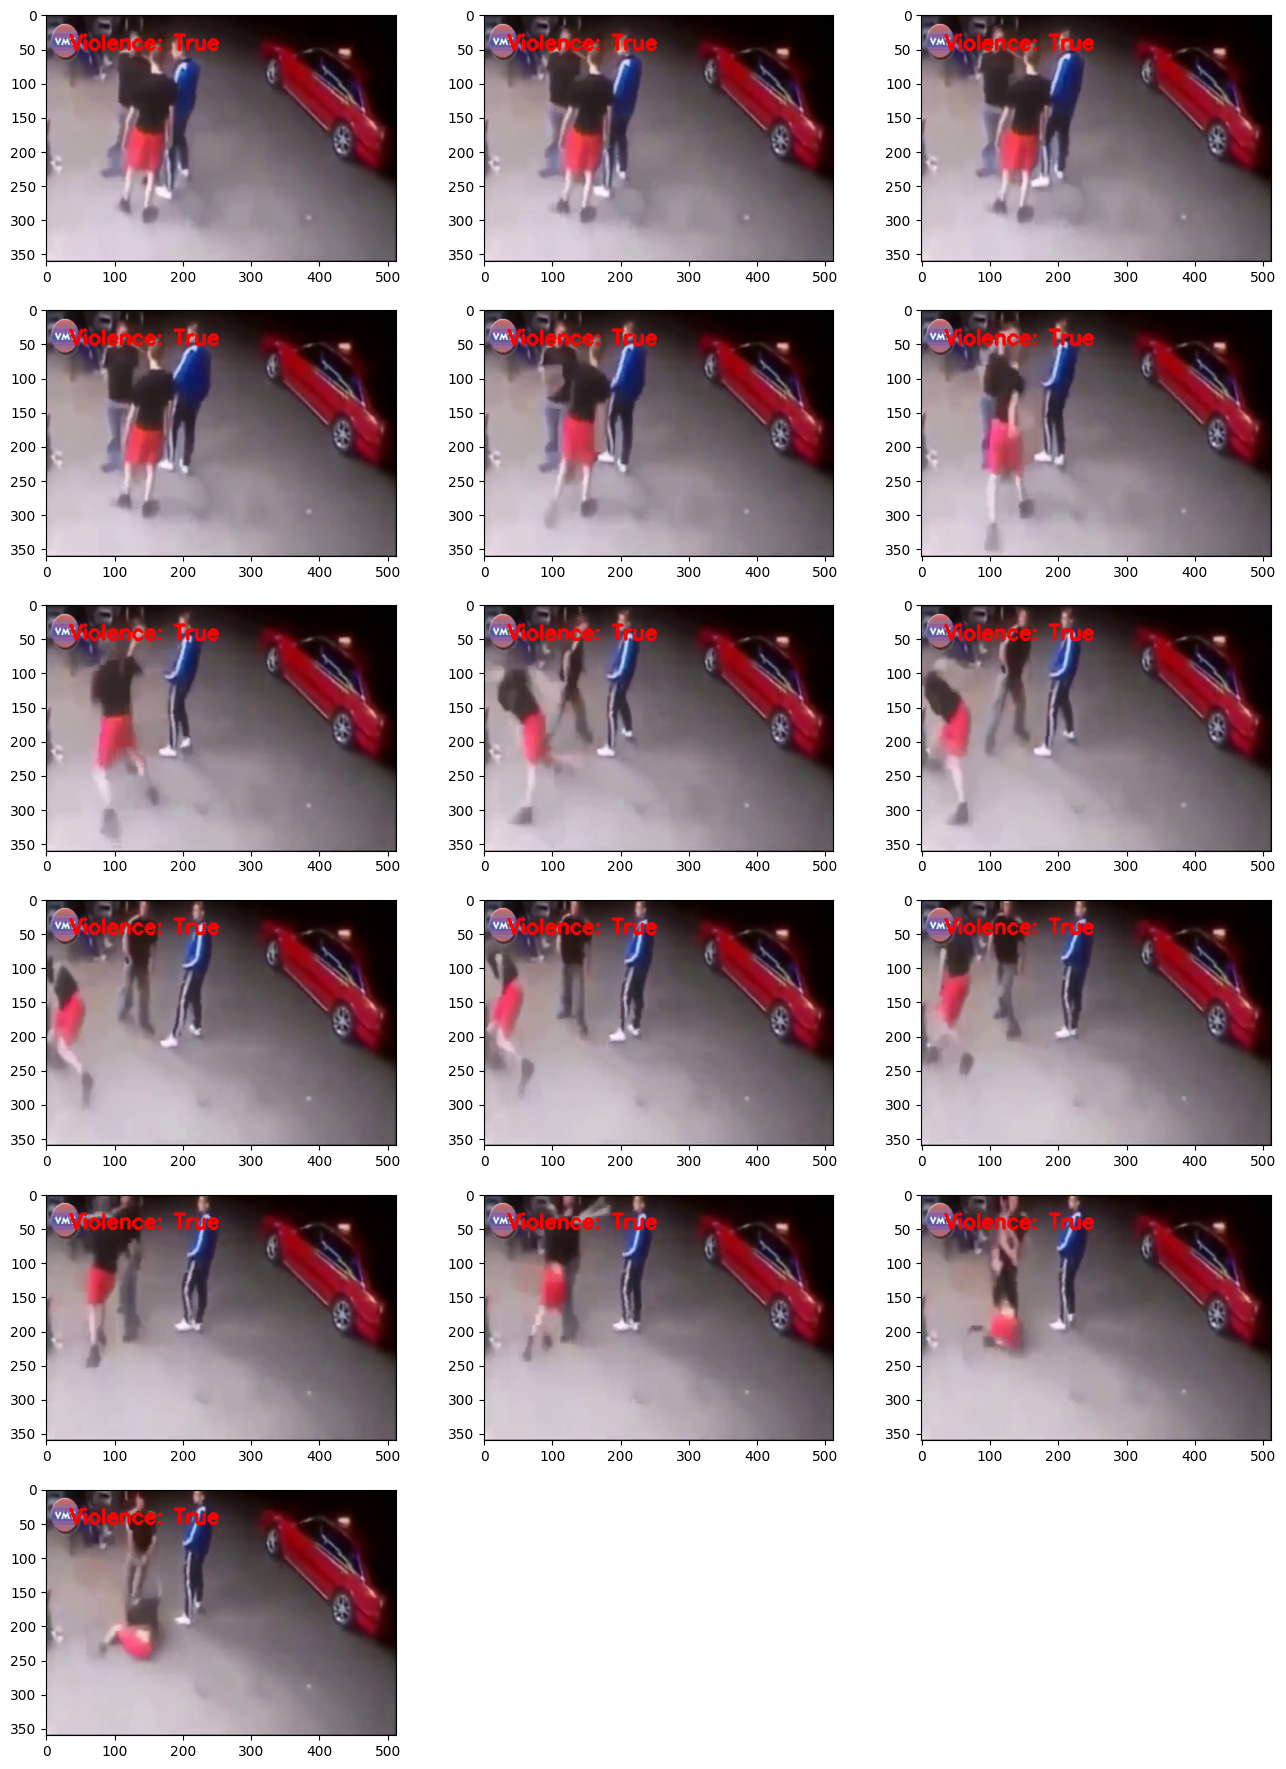

Cleaning up...


In [50]:
print_results(Violence)

In [30]:
NonViolence=r"./input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_309.mp4"
play(NonViolence)

Loading model ...
1/1 [==============================] - 0s 46ms/step


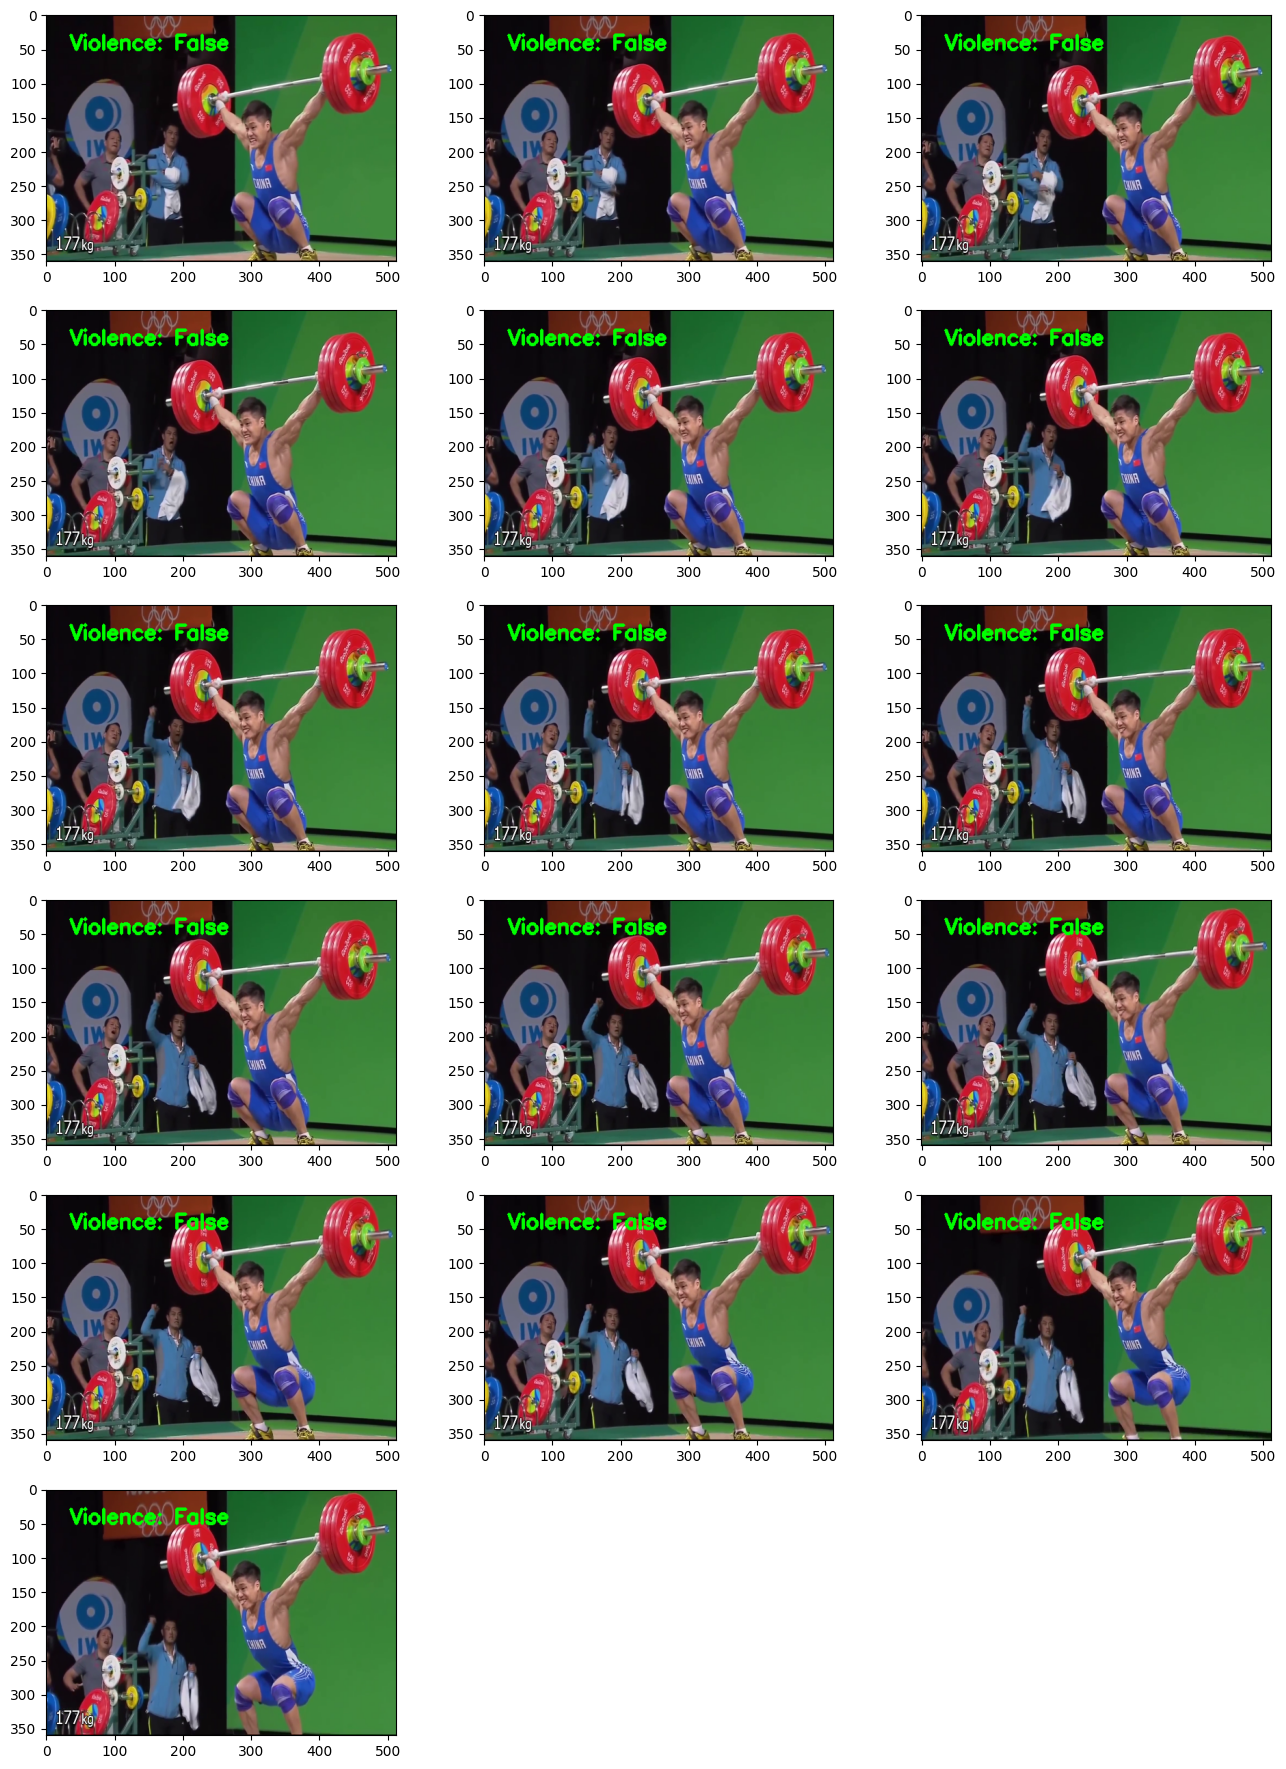

Cleaning up...


In [49]:
print_results(NonViolence, limit=30)

# Thus, we have obtained a Violence Detection Surveillance System with high accuracy and very little loss. We use ResNetV2 as it has many attributes which will give the highest accuracy for a model.